<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week6/RNN_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import kerastuner as kt
from kerastuner.tuners import RandomSearch

In [26]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
# Memeriksa apakah GPU tersedia
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [28]:
# Load data
url = 'https://raw.githubusercontent.com/farrelrassya/teachingMLDL/main/02.%20Deep%20Learning/06.%20Week%206/Datasets/DeteksiSarkasme.json'
response = requests.get(url)

if response.status_code == 200:
    try:
        # Try to read as newline-delimited JSON
        df = pd.read_json(url, lines=True)
    except ValueError:
        # If that fails, try to read as a list of dictionaries
        data = json.loads(response.text)
        df = pd.DataFrame(data)
else:
    print("Failed to download data, check URL or internet connection.")

print("Data shape:", df.shape)
print("\nSample data:")
print(df.head())

Data shape: (26709, 3)

Sample data:
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  


In [29]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Display class distribution
print("\nClass distribution:")
print(df['is_sarcastic'].value_counts())
print(df['is_sarcastic'].value_counts(normalize=True) * 100)


Missing values in each column:
article_link    0
headline        0
is_sarcastic    0
dtype: int64

Class distribution:
is_sarcastic
0    14985
1    11724
Name: count, dtype: int64
is_sarcastic
0    56.104684
1    43.895316
Name: proportion, dtype: float64


In [30]:
# Data preprocessing
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters, numbers, and extra whitespaces
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Apply preprocessing to headline column
df['headline_processed'] = df['headline'].apply(preprocess_text)

In [31]:
# Display some processed examples
print("\nPreprocessed examples:")
for i in range(3):
    print(f"Original: {df['headline'].iloc[i]}")
    print(f"Processed: {df['headline_processed'].iloc[i]}")
    print(f"Is Sarcastic: {df['is_sarcastic'].iloc[i]}")
    print("---")


Preprocessed examples:
Original: former versace store clerk sues over secret 'black code' for minority shoppers
Processed: former versace store clerk sues over secret black code for minority shoppers
Is Sarcastic: 0
---
Original: the 'roseanne' revival catches up to our thorny political mood, for better and worse
Processed: the roseanne revival catches up to our thorny political mood for better and worse
Is Sarcastic: 0
---
Original: mom starting to fear son's web series closest thing she will have to grandchild
Processed: mom starting to fear sons web series closest thing she will have to grandchild
Is Sarcastic: 1
---


In [32]:
# Split the data into training and testing sets
X = df['headline_processed']
y = df['is_sarcastic']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")


Training set size: 21367
Testing set size: 5342


In [33]:
# Tokenization and sequence padding
max_words = 10000  # Maximum number of words to keep
max_len = 50       # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [34]:
# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print(f"\nVocabulary size: {len(tokenizer.word_index) + 1}")
print(f"Shape of padded training sequences: {X_train_pad.shape}")
print(f"Shape of padded testing sequences: {X_test_pad.shape}")



Vocabulary size: 24866
Shape of padded training sequences: (21367, 50)
Shape of padded testing sequences: (5342, 50)


In [44]:
# Function to build and evaluate model
def build_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=64,
        validation_split=0.1,
        callbacks=[early_stopping, model_checkpoint],
        verbose=1
    )

    # Evaluate the model
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\nTest Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print(f"Test AUC: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Training history plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'history': history
    }


In [45]:
def build_basic_rnn_model():
    embedding_dim = 128
    vocab_size = len(tokenizer.word_index) + 1

    # Create model using Functional API for better parameter visualization
    inputs = tf.keras.Input(shape=(max_len,))

    # Embedding layer
    x = Embedding(vocab_size, embedding_dim)(inputs)

    # RNN layers
    x = Bidirectional(SimpleRNN(64, return_sequences=True))(x)
    x = Bidirectional(SimpleRNN(32))(x)

    # Dense layers
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create and compile the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Display model summary
    model.summary()

    return model

In [46]:
basic_rnn_model = build_basic_rnn_model()


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_5 (Embedding)              │ (None, 50, 128)             │       3,182,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 50, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 64)                  │          10,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,222,081 (12.29 MB)

 Trainable params: 3,222,081 (12.29 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7034 - loss: 0.5490

301/301 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7037 - loss: 0.5487 - val_accuracy: 0.8526 - val_loss: 0.3428
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9019 - loss: 0.2435 - val_accuracy: 0.8343 - val_loss: 0.4342
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9613 - loss: 0.1107 - val_accuracy: 0.8259 - val_loss: 0.5978
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9852 - loss: 0.0433 - val_accuracy: 0.8217 - val_loss: 0.7474
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9915 - loss: 0.0272 - val_accuracy: 0.8255 - val_loss: 0.8782
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9942 - loss: 0.0169 - val_accuracy: 0.8362 - val_loss: 0.8890
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step

Test Accuracy: 0.8486
Test Precision: 0.8246
Test Recall: 0.8320
Test F1 Score: 0.8283
Test AUC: 0.9278


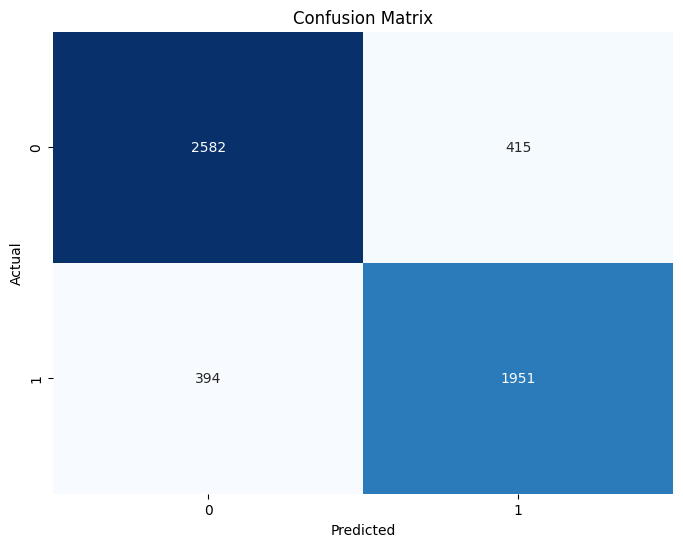

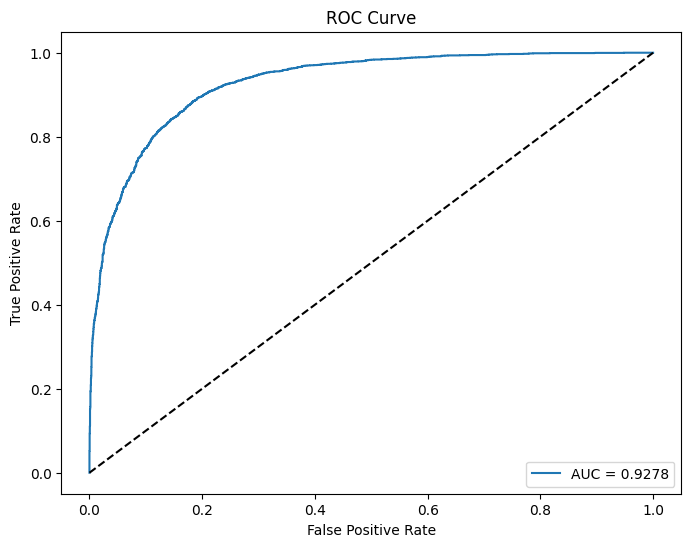

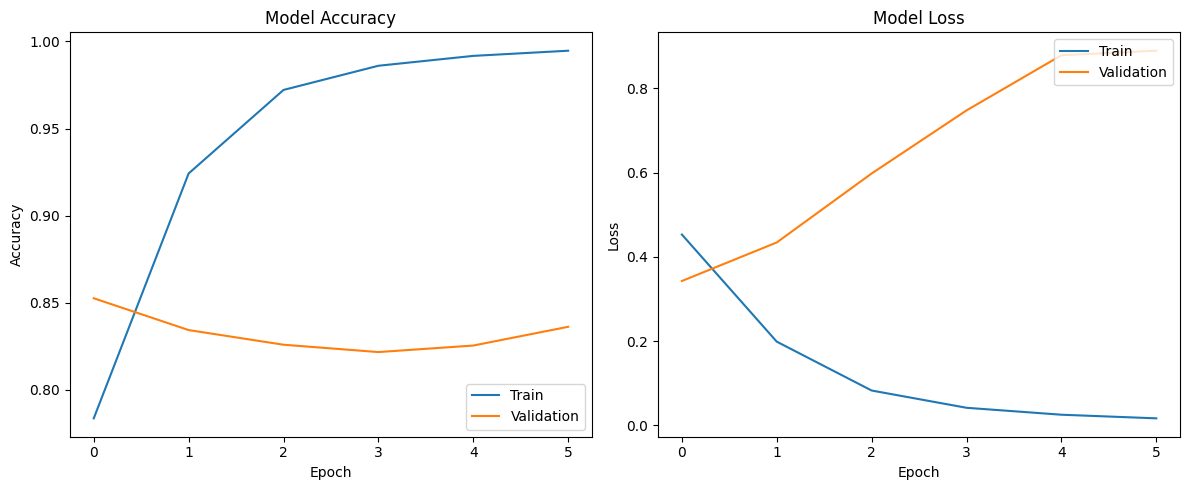

In [47]:
basic_rnn_results = build_and_evaluate_model(basic_rnn_model, X_train_pad, y_train, X_test_pad, y_test)


In [49]:
# Hyperparameter tuning with Keras Tuner
class BasicRNNHyperModel(kt.HyperModel):
    def __init__(self, input_shape, vocab_size):
        self.input_shape = input_shape
        self.vocab_size = vocab_size

    def build(self, hp):
        # Define hyperparameters to search
        embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=64)
        rnn_units_1 = hp.Int('rnn_units_1', min_value=32, max_value=128, step=32)
        rnn_units_2 = hp.Int('rnn_units_2', min_value=16, max_value=64, step=16)
        dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
        learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        use_bidirectional = hp.Boolean('use_bidirectional')

        # Build model based on hyperparameters
        model = Sequential()
        model.add(Embedding(self.vocab_size, embedding_dim, input_length=self.input_shape))

        # First RNN layer
        if use_bidirectional:
            model.add(Bidirectional(SimpleRNN(rnn_units_1, return_sequences=True)))
        else:
            model.add(SimpleRNN(rnn_units_1, return_sequences=True))

        # Second RNN layer
        if use_bidirectional:
            model.add(Bidirectional(SimpleRNN(rnn_units_2)))
        else:
            model.add(SimpleRNN(rnn_units_2))

        model.add(Dense(rnn_units_1, activation='relu'))
        model.add(Dropout(dropout_rate))
        model.add(Dense(1, activation='sigmoid'))

        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

        return model

In [55]:
# Initialize hyperparameter tuning
input_shape = max_len
vocab_size = len(tokenizer.word_index) + 1

hypermodel = BasicRNNHyperModel(input_shape, vocab_size)
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=4,
    executions_per_trial=1,
    directory='hyperparameter_tuning',
    project_name='sarcasm_detection_basic_rnn'
)

Reloading Tuner from hyperparameter_tuning/sarcasm_detection_basic_rnn/tuner0.json


In [56]:
# Search for the best hyperparameters
tuner.search(
    X_train_pad, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)


In [57]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
print(f"- Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"- First RNN Units: {best_hps.get('rnn_units_1')}")
print(f"- Second RNN Units: {best_hps.get('rnn_units_2')}")
print(f"- Use Bidirectional: {best_hps.get('use_bidirectional')}")
print(f"- Dropout Rate: {best_hps.get('dropout_rate')}")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")


Best Hyperparameters:
- Embedding Dimension: 64
- First RNN Units: 96
- Second RNN Units: 48
- Use Bidirectional: True
- Dropout Rate: 0.2
- Learning Rate: 0.0001792012996707606



Training model with best hyperparameters...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


301/301 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7149 - loss: 0.5319

301/301 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.7151 - loss: 0.5316 - val_accuracy: 0.8489 - val_loss: 0.3394
Epoch 2/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9080 - loss: 0.2310 - val_accuracy: 0.8166 - val_loss: 0.5253
Epoch 3/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9533 - loss: 0.1256 - val_accuracy: 0.8152 - val_loss: 0.6821
Epoch 4/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9793 - loss: 0.0623 - val_accuracy: 0.8231 - val_loss: 0.7695
Epoch 5/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9902 - loss: 0.0269 - val_accuracy: 0.8264 - val_loss: 0.8204
Epoch 6/10
301/301 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9931 - loss: 0.0199 - val_accuracy: 0.8161 - val_loss: 0.8709
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step

Test Accuracy: 0.8517
Test Precision: 0.8132
Test Recall: 0.8597
Test F1 Score: 0.8358
Test AUC: 0.9287


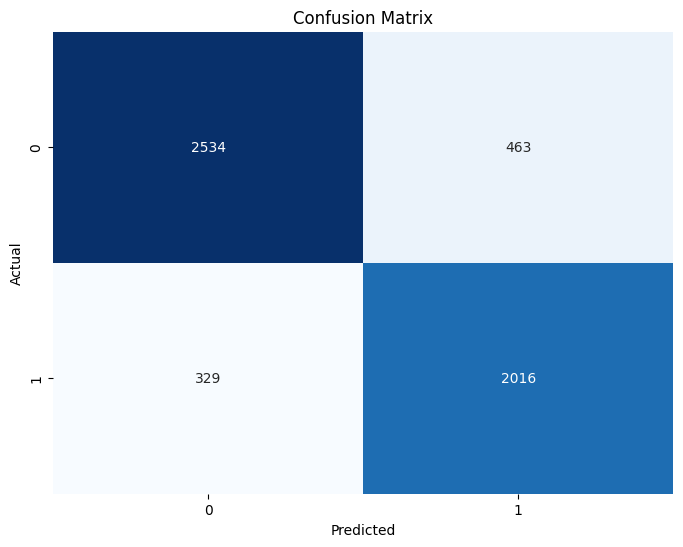

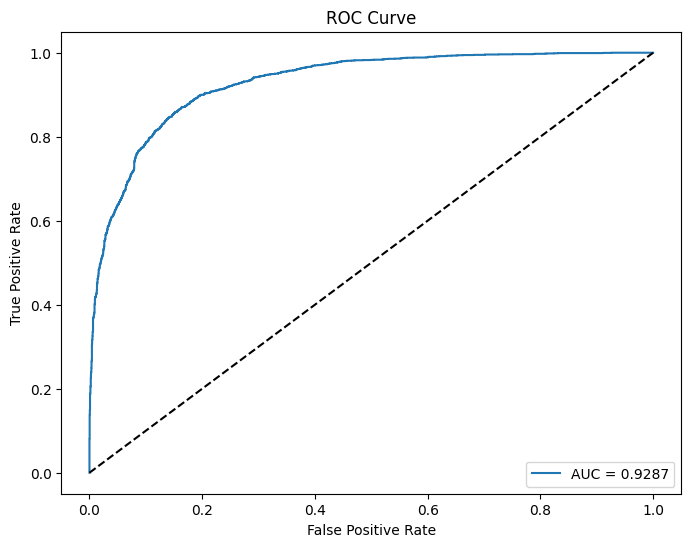

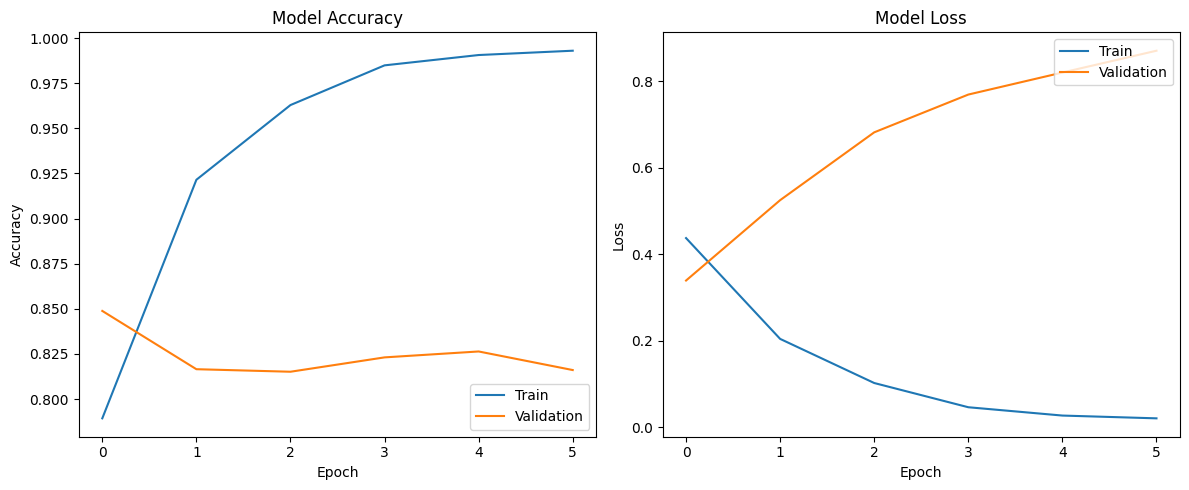

In [58]:
# Build and train the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
print("\nTraining model with best hyperparameters...")

# Evaluate the best model
best_model_results = build_and_evaluate_model(best_model, X_train_pad, y_train, X_test_pad, y_test)


In [59]:
# Function to predict sarcasm in new text
def predict_sarcasm(text, model, tokenizer, max_len=50):
    # Preprocess the text
    processed_text = preprocess_text(text)
    # Convert to sequence
    sequence = tokenizer.texts_to_sequences([processed_text])
    # Pad sequence
    padded_sequence = pad_sequences(sequence, maxlen=max_len, padding='post', truncating='post')
    # Make prediction
    prediction = model.predict(padded_sequence)[0][0]
    # Return result
    return {
        'text': text,
        'processed': processed_text,
        'prediction_score': float(prediction),
        'is_sarcastic': 'Yes' if prediction > 0.5 else 'No',
        'confidence': float(max(prediction, 1-prediction))
    }

In [60]:
# Test the model with some examples
test_examples = [
    "Scientists discover that eating chocolate prevents weight gain",
    "Breaking News: Politicians actually keep their promises",
    "New study shows that exercise is good for health",
    "Local man discovers secret to eternal happiness: just be happy"
]

print("\nTesting the model with some examples:")
for example in test_examples:
    result = predict_sarcasm(example, best_model, tokenizer)
    print(f"Text: {result['text']}")
    print(f"Prediction: {result['is_sarcastic']} (Score: {result['prediction_score']:.4f}, Confidence: {result['confidence']:.2%})")
    print("---")



Testing the model with some examples:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step
Text: Scientists discover that eating chocolate prevents weight gain
Prediction: Yes (Score: 0.9319, Confidence: 93.19%)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Text: Breaking News: Politicians actually keep their promises
Prediction: Yes (Score: 0.7671, Confidence: 76.71%)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Text: New study shows that exercise is good for health
Prediction: No (Score: 0.2421, Confidence: 75.79%)
---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Text: Local man discovers secret to eternal happiness: just be happy
Prediction: Yes (Score: 0.9815, Confidence: 98.15%)
---


In [61]:
# Summary of model performance
print("\nModel Performance Summary:")
print(f"Accuracy: {best_model_results['accuracy']:.4f}")
print(f"Precision: {best_model_results['precision']:.4f}")
print(f"Recall: {best_model_results['recall']:.4f}")
print(f"F1 Score: {best_model_results['f1']:.4f}")
print(f"AUC: {best_model_results['auc']:.4f}")


Model Performance Summary:
Accuracy: 0.8517
Precision: 0.8132
Recall: 0.8597
F1 Score: 0.8358
AUC: 0.9287
